In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

In [2]:
print(tf.__version__)
print(keras.__version__)

2.1.3
2.3.0-tf


In [3]:
image_datas = glob('./Data_faceShape/*.png')

In [4]:
class_name = ['계란형', '마름모형', '하트형', '땅콩형', '육각형', '둥근형']
label_dic = {"계란형":0, "마름모형":1, "하트형":2, "땅콩형":3, "육각형":4, "둥근형":5}

hair_dic = {0:"- 업 스타일, 포니테일 스타일\n- 컬이 들어간 레이어드 S컬 파마\n- 중간 길이의 머리에 가벼운 웨이브\n- 보브컷", 
            1:"- 여신 앞머리\n- 턱선 기장의 앞머리\n- 굵은 웨이브 펌\n- 단발 기장의 히피펌 혹은 러블리펌", 
            2:"- 귀 높이부터 웨이브가 들어간 헤어스타일\n- 짧은 단발머리에 C컬 파마 또는 앞머리를 내리거나 턱선 근처 무거운 느낌의 굵은 S컬 파마\n- 머리를 길게 길러 굵은 웨이브의 불륨감\n- 똥머리, 포니테일\n- 턱선에서 어깨 길이에 뱅 스타일\n- 넓은 이마는 시스루 뱅 스타일", 
            3:"- 페이스라인 컷\n- 아랫부분에 층을 쳐서 볼륨감", 
            4:"- 앞머리를 없애거나 시스루 뱅\n- 끝이 사선으로 된 커트\n- 긴 머리의 경우 턱 윗부분부터 굵은 웨이브", 
            5:"- 이마를 드러내는 헤어스타일\n- 윗머리 볼륨감\n- 턱선까지 오는 단발\n- 가슴 중간을 넘는 긴 기장"}

In [5]:
X = []
y = []

for imgname in image_datas:
    image = Image.open(imgname).convert('RGB')
    image = image.resize((128,128))
    image = np.array(image)
    X.append(image)

In [6]:
import pandas as pd

_label = pd.read_csv("./data_face_shape.csv", encoding='utf-8')
for i in range(len(_label['faceShape'])):
    label = label_dic[_label['faceShape'][i]]
    y.append(label)

In [7]:
X = np.array(X)

In [8]:
X[0].shape

(128, 128, 3)

In [9]:
y = np.array(y)

In [10]:
train_img, test_img, train_label, test_label = train_test_split(X, y, test_size=0.2, random_state=44)

train_label = train_label[..., tf.newaxis]
test_label = test_label[..., tf.newaxis]

train_img.shape, train_label.shape, test_img.shape, test_label.shape

((129, 128, 128, 3), (129, 1), (33, 128, 128, 3), (33, 1))

In [11]:
N_TRAIN = train_img.shape[0]
N_TEST = test_img.shape[0]

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


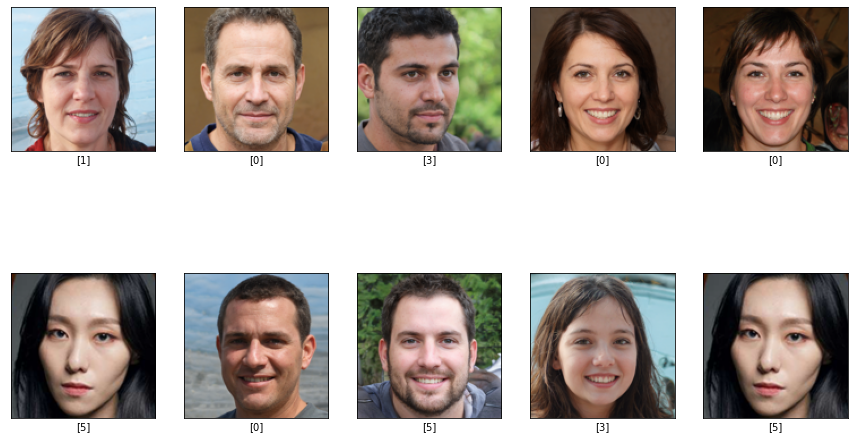

In [12]:
# 데이터 확인
plt.figure(figsize=(15,9))
for i in range(10):
    img_idx = np.random.randint(0, 100)
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[img_idx])

    plt.xlabel(train_label[img_idx])

In [13]:
## pixel 값을 0~1 사이 범위로 조정
train_img = train_img.astype(np.float32) / 255.
test_img = test_img.astype(np.float32) / 255.

# label을 onehot-encoding
train_label = keras.utils.to_categorical(train_label)
test_label = keras.utils.to_categorical(test_label)

In [14]:
## Hyper-parameters
learning_rate = 0.000001
n_epochs = 20
n_batch = 12
n_class = 6

In [15]:
## dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_label)).shuffle(buffer_size=162).batch(n_batch).repeat()

In [16]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    test_img, test_label)).batch(n_batch)

In [17]:
## Sequential API를 사용하여 model 구성
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3,
                                 activation='relu', padding='SAME',
                                 input_shape=(128, 128, 3)))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                                 activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                                 activation='relu', padding='SAME'))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
#     model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(6, activation='softmax'))
    return model

In [18]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0

In [19]:
## Parameters for training
steps_per_epoch = N_TRAIN//n_batch
validation_steps = N_TEST//n_batch
print(steps_per_epoch, validation_steps)

10 2


In [20]:
## Training
history = model.fit(train_dataset, epochs=n_epochs, steps_per_epoch=steps_per_epoch,
                   validation_data=test_dataset, validation_steps=validation_steps)

[2021-12-12 02:15:12.973 ip-172-16-66-186:7230 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-12-12 02:15:13.008 ip-172-16-66-186:7230 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Train for 10 steps, validate for 2 steps
Epoch 1/20
10/10 [==============================] - 4s 356ms/step - loss: 1.7584 - accuracy: 0.1917 - val_loss: 1.7403 - val_accuracy: 0.2500
Epoch 2/20
10/10 [==============================] - 3s 285ms/step - loss: 1.7411 - accuracy: 0.2479 - val_loss: 1.7264 - val_accuracy: 0.2917
Epoch 3/20
10/10 [==============================] - 3s 273ms/step - loss: 1.7247 - accuracy: 0.2479 - val_loss: 1.7135 - val_accuracy: 0.3750
Epoch 4/20
10/10 [==============================] - 3s 285ms/step - loss: 1.7186 - accuracy: 0.2991 - val_loss: 1.7015 - val_accuracy: 0.3333
Epoch 5/20
10/10 [==============================] - 3s 292ms/step - loss: 1.7027 - accuracy: 0.3162 - val_loss: 1.6908

In [21]:
model.evaluate(test_dataset)

3/3 [==============================] - 0s 62ms/step - loss: 1.7105 - accuracy: 0.3333


[1.7105493942896526, 0.33333334]

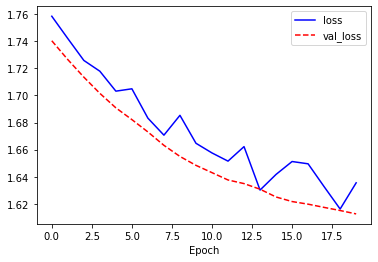

In [22]:
## Plot losses
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

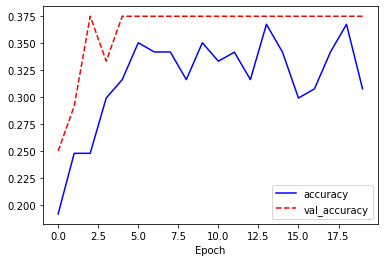

In [23]:
## Plot accuracy
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [24]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                   100*np.max(predictions_array),
                                   class_name[true_label]), color=color, fontproperties=fontprop)
    print("{} 추천 헤어스타일\n{}\n".format(class_name[predicted_label], hair_dic[predicted_label]))

둥근형 추천 헤어스타일
- 이마를 드러내는 헤어스타일
- 윗머리 볼륨감
- 턱선까지 오는 단발
- 가슴 중간을 넘는 긴 기장



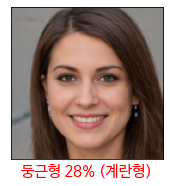

In [25]:
import matplotlib.font_manager as fm

path = './NanumBarunGothic.ttf'
fontprop = fm.FontProperties(fname=path, size=15)

rnd_idx = np.random.randint(1, N_TEST//n_batch)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 1
    num_cols = 1
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())   

    break